In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai import vision as vision
from fastai.metrics import error_rate

In [3]:
bs = 32

In [5]:
help(vision.untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [6]:
path = vision.untar_data(vision.URLs.PETS); 
path

A new version of the dataset is available.


PosixPath('/home/tornike/.fastai/data/oxford-iiit-pet')

In [9]:
path.ls()

[PosixPath('/home/tornike/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/tornike/.fastai/data/oxford-iiit-pet/annotations')]

In [17]:
path_anno = path/'annotations'
path_img = path/'images'

In [19]:
fnames = vision.get_image_files(path_img)
fnames[:3]

[PosixPath('/home/tornike/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_65.jpg'),
 PosixPath('/home/tornike/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_13.jpg'),
 PosixPath('/home/tornike/.fastai/data/oxford-iiit-pet/images/chihuahua_92.jpg')]

In [31]:
import numpy as np
np.random.seed(42)
pat = r'/([^/]+)_\d+.jpg$'
pat = r'(\w+)_\d+.jpg'

In [36]:
import re

txt = 'Doberman_cool_12.jpg'
re.compile(pat).findall(txt)

['Doberman_cool']

In [83]:
data = vision.ImageDataBunch.from_name_re(
    path_img,
    fnames,
    pat,
    bs=bs,
    ds_tfms=vision.get_transforms(),
#     size=64,
    size=224,
)
data = data.normalize(vision.imagenet_stats)

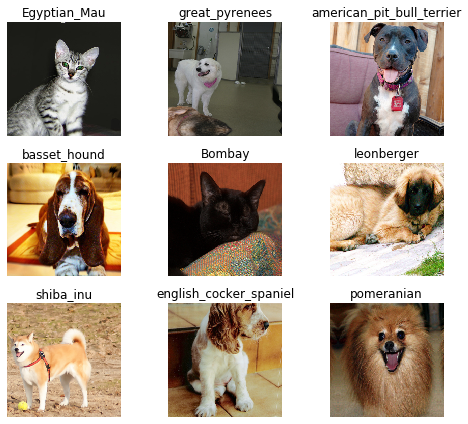

In [84]:
data.show_batch(rows=3, figsize=(7,6))

In [81]:
print(data.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [82]:
len(data.classes), data.c  

(37, 37)

## Training: resnet34

In [86]:
learn = vision.cnn_learner(data, 
                           vision.models.resnet34,
                          metrics=vision.error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/tornike/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:16<00:00, 5.40MB/s]


In [87]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [88]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.967499,0.444570,0.140731,12:56
1,0.559760,0.332235,0.100812,12:54
2,0.389414,0.267825,0.088633,13:16
3,0.247185,0.246785,0.079838,13:02


In [89]:
learn.save('stage-1')

In [103]:
vision.doc(learn.fit_one_cycle)

## Results

In [91]:
interp = vision.ClassificationInterpretation.from_learner(
    learn
)

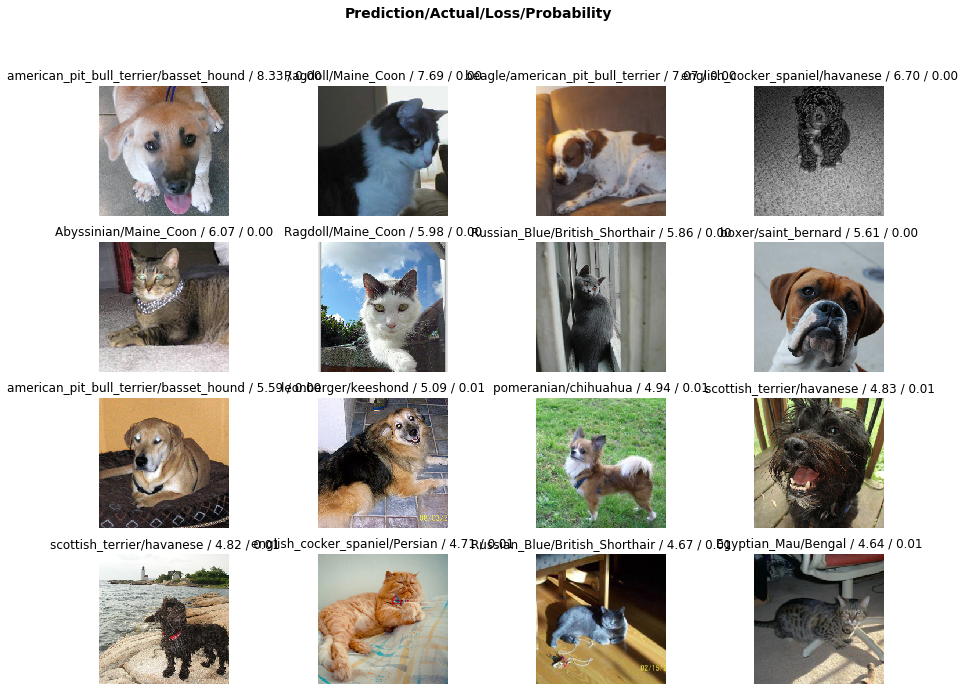

In [96]:
interp.plot_top_losses(16, figsize=(15,11))

In [99]:
vision.doc(interp.plot_top_losses)

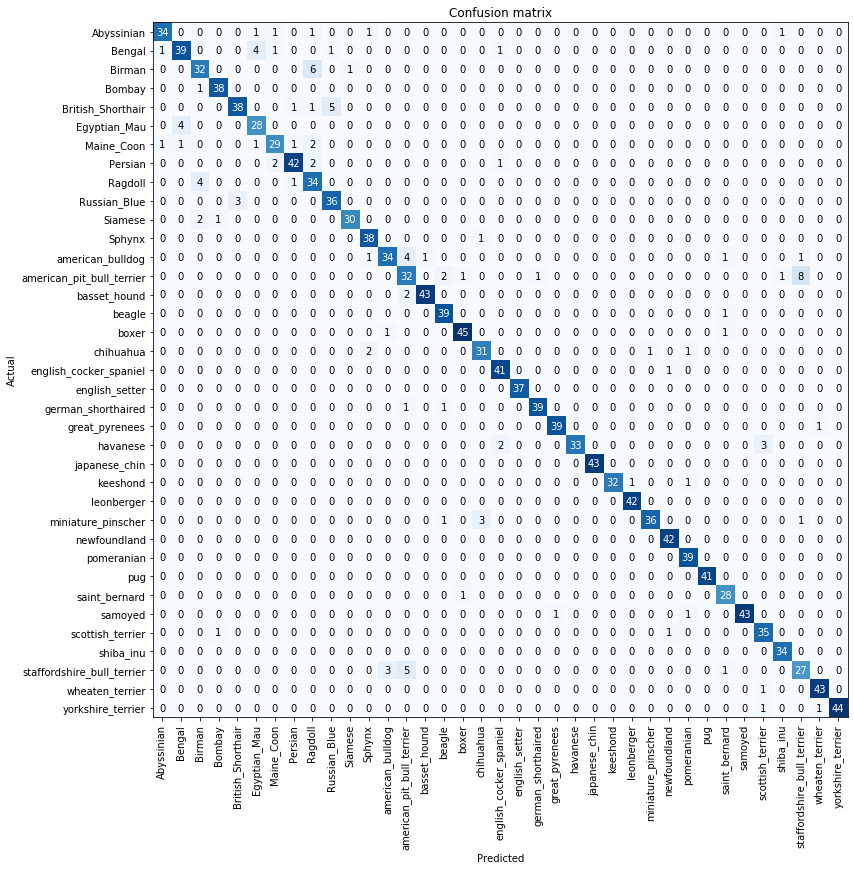

In [100]:
interp.plot_confusion_matrix(figsize=(12,12))

In [101]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 8),
 ('Birman', 'Ragdoll', 6),
 ('British_Shorthair', 'Russian_Blue', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('Bengal', 'Egyptian_Mau', 4),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Ragdoll', 'Birman', 4),
 ('american_bulldog', 'american_pit_bull_terrier', 4),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('havanese', 'scottish_terrier', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('Maine_Coon', 'Ragdoll', 2),
 ('Persian', 'Maine_Coon', 2),
 ('Persian', 'Ragdoll', 2),
 ('Siamese', 'Birman', 2),
 ('american_pit_bull_terrier', 'beagle', 2),
 ('basset_hound', 'american_pit_bull_terrier', 2),
 ('chihuahua', 'Sphynx', 2),
 ('havanese', 'english_cocker_spaniel', 2)]

## Unfreezing, fine-tuning and learning rates

In [104]:
learn.unfreeze()

In [105]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.867699,0.420605,0.123816,19:41


In [106]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
staffordshire_bull_terrier,chihuahua,saint_bernard,shiba_inu,Ragdoll
Path: /home/tornike/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Sphynx,american_pit_bull_terrier,american_pit_bull_terrier,newfoundland,english_setter
Path: /home/tornike/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(


In [107]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


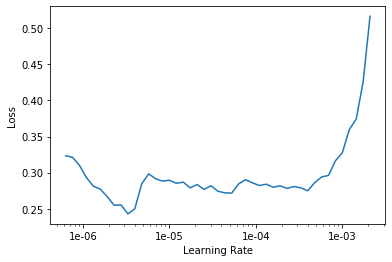

In [108]:
learn.recorder.plot()

## Training: resnet50

In [122]:
data = vision.ImageDataBunch.from_name_re(
    path_img, fnames,
    pat,
    ds_tfms=vision.get_transforms(),
    size=224,
    bs=32
).normalize(vision.imagenet_stats)

In [123]:
learn = vision.cnn_learner(data, 
                          vision.models.resnet50,
                          metrics=vision.error_rate
)

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time


In [120]:
learn.fit_one_cycle(8)
learn.save('stage-1-50')

epoch,train_loss,valid_loss,error_rate,time
0,3.064932,2.642671,0.671854,03:01
1,2.781533,2.228773,0.619756,03:08
2,2.197717,1.833815,0.542625,02:49
3,1.865736,1.580630,0.472936,03:14
4,1.660440,1.425263,0.423545,03:14
5,1.497367,1.307695,0.412720,03:14


KeyboardInterrupt: 

In [ ]:
learn.load('stage-1-50')